# Constructing Scalar Models

Once the modes have been found, we can then make use of them to construct scalar models of our meta-atoms.

In [1]:
# setup 2D plotting 
%matplotlib inline
from openmodes.ipython import matplotlib_defaults
matplotlib_defaults()
import matplotlib.pyplot as plt

# the numpy library contains useful mathematical functions
import numpy as np

# import useful python libraries
import os.path as osp

# import the openmodes package
import openmodes
from openmodes.sources import PlaneWaveSource

## Initialising simulation

In [2]:
sim = openmodes.Simulation(notebook=True)
mesh = sim.load_mesh(osp.join(openmodes.geometry_dir, "SRR.geo"), parameters={'inner_radius': 2.5e-3}, mesh_tol=0.8e-3)
ring = sim.place_part(mesh)

Pruned cell types: vertex, line


## Searching for modes

In [3]:
start_freq = 2e9
start_s = 2j*np.pi*start_freq

num_modes = 4
estimates = sim.estimate_poles(start_s, modes=num_modes, cauchy_integral=False)
refined = sim.refine_poles(estimates, rel_tol=1e-12)
modes = refined.add_conjugates()

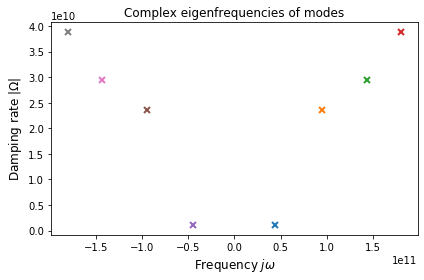

In [4]:
plt.figure()
plt.plot(modes.s.imag, np.abs(modes.s.real), 'x')
plt.xlabel('Frequency $j\omega$')
plt.ylabel('Damping rate $|\Omega|$')
plt.title('Complex eigenfrequencies of modes')
plt.tight_layout()
plt.show()

Having found these modes, we can now use them as a basis for constructing models of our resonator which can describe all the dynamics in a relatively simple form.

## Exact solution to extinction

Now we utilise this model to calculate the extinction cross section of each mode. First we setup the incident wave polarisation and direction and the frequency range of interest.

In [5]:
num_freqs = 101
freqs = np.linspace(1e9, 30e9, num_freqs)

e_inc = np.array([1.0, 1.0, 0])
k_dir = np.array([0, 0, 1])
plane_wave = PlaneWaveSource(e_inc, k_dir, p_inc =1.0)

area = np.pi*(0.5*mesh.max_distance)**2

extinction = np.empty(num_freqs, np.complex128)
extinction_modes = np.empty((num_freqs, len(modes)), np.complex128)

For comparison purposes we calculate the extinction directly, and time how long this calculation takes. Note that if you increase the mesh density or model a more complex structure, the direct calculation can become very slow, since a large impedance matrix must be filled and solved at every frequency.

In [6]:
%%timeit -n 1 -r 1

for freq_count, s in sim.iter_freqs(freqs):
    Z = sim.impedance(s)
    V = sim.source_vector(plane_wave, s)
    extinction[freq_count] = np.vdot(V, Z.solve(V))

2.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Solution based on modes

Knowing the location of the mode frequencies (or poles) $s_n$, together with the the mode current distributions $\mathbf{v}_n$, these form a compact but accurate model of the currents $\mathbf{j}$ excited on the meta-atom by an incident field $\mathbf{E}$. 

$$\mathbf{j}(\mathbf{r}, s) = \sum_{n} \left(\frac{1}{s - s_n} + \frac{1}{s_n}\right)\mathbf{v}_{n}(\mathbf{r}) \frac{\int \mathbf{v}_{n}(\mathbf{r}')\cdot\mathbf{E}(\mathbf{r}', s) \mathrm{d} \mathbf{r}'}
{ \int \mathbf{v}_{n}(\mathbf{r}')\cdot \frac{d}{ds}\mathbf{Z}(s)\big|_{s=s_n} \cdot \mathbf{v}_{n}(\mathbf{r}') \mathrm{d} \mathbf{r}'} $$

Note that the normalisation integration in the denominator to the derivative of the impedance matrix $\mathbf{Z}$ has already been applied to the mode currents. Now we calculate the extinction based on this model

In [7]:
%%timeit -n 1 -r 1
for freq_count, s in sim.iter_freqs(freqs):
    V = sim.source_vector(plane_wave, s)    
    I_modes = (1/(s - modes.s) + 1/modes.s)*modes.vl.dot(V)
    extinction_modes[freq_count] = V.vdot(modes.vr*I_modes)

161 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Timings will vary depending on the exact structure to be solved and the performance of the computer. However in all cases, once the scalar model has been constructed, the system can be solved for different frequencies, input polarisation etc with very low computational cost. This becomes much more important for complex structures with many mesh elements.

We can now see that the extinction cross-section contribution from each of the modes.

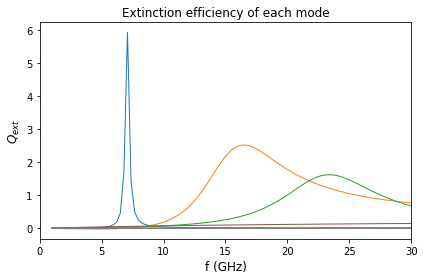

In [8]:
plt.figure()
plt.plot(freqs*1e-9, extinction_modes.real/area);
plt.xlim(0, freqs[-1]*1e-9)
plt.xlabel('f (GHz)')
plt.ylabel('$Q_{ext}$')
plt.title('Extinction efficiency of each mode')
plt.tight_layout()
plt.show()

In addition, we obtain the reactive stored enerrgy of each mode, given by $W_{m}-W_{e}$, the difference between magnetic and electric and stored energies. At resonance these terms go through zero, following from the imaginary part of the admittance.


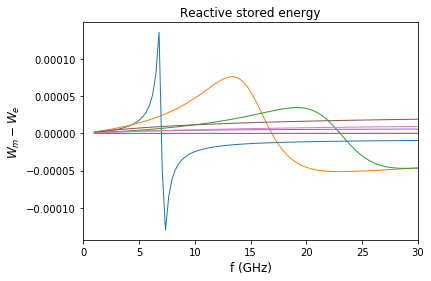

In [9]:
plt.figure()
plt.plot(freqs*1e-9, extinction_modes.imag)
plt.xlim(0, freqs[-1]*1e-9)
plt.xlabel('f (GHz)')
plt.ylabel('$W_m-W_e$')
plt.title('Reactive stored energy')
plt.show()

## Compare model with exact solution 
 
The accuracy of this modal decomposition can be checked by comparison with the direct numerical calculation

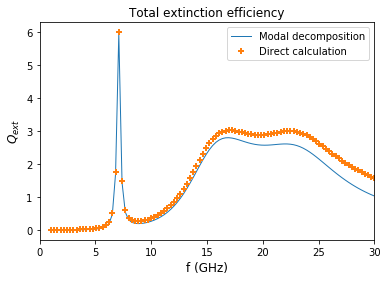

In [10]:
plt.figure()
plt.plot(freqs*1e-9, extinction.real/area)
plt.plot(freqs*1e-9, np.sum(extinction_modes.real, axis=1)/area, '+')
plt.legend(['Modal decomposition', 'Direct calculation'])
plt.xlim(0, freqs[-1]*1e-9)
plt.xlabel('f (GHz)')
plt.ylabel('$Q_{ext}$')
plt.title('Total extinction efficiency')
plt.show()

At low frequencies agreement is good, but the extinction is over-estimated at high frequencies. This discrepency is mostly due to some higher order modes which have been missed. 

In a later example, we will show how to obtain higher accuracy from the models. However, if we are using this is SRR in a metamaterial, we most likely only care about the frequency region of the fundamental mode, which is very accurately modelled.